In [2]:
%pylab inline
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression

import sys
sys.path.append('../../Notebooks/')
from guth import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Populating the interactive namespace from numpy and matplotlib


In [3]:
Xi_Results = {}
Xi_Losses = {}
Taus = [np.round(0.7*j,1) for j in range(16)]

for j in range(len(Taus)):
    
    tau = Taus[j]
    base_path = '../saved_results/'
    Xi_Results[tau] = np.load(base_path+'results_tau'+str(tau)+'.npy',allow_pickle=True).item()    
    NN_dict = np.load(base_path+'P_to_q_tau'+str(tau)+'.npy',allow_pickle=True).item()
    train_loss = NN_dict['train_loss']
    val_loss = NN_dict['val_loss']
    Xi_Losses[tau] = [train_loss, val_loss] 

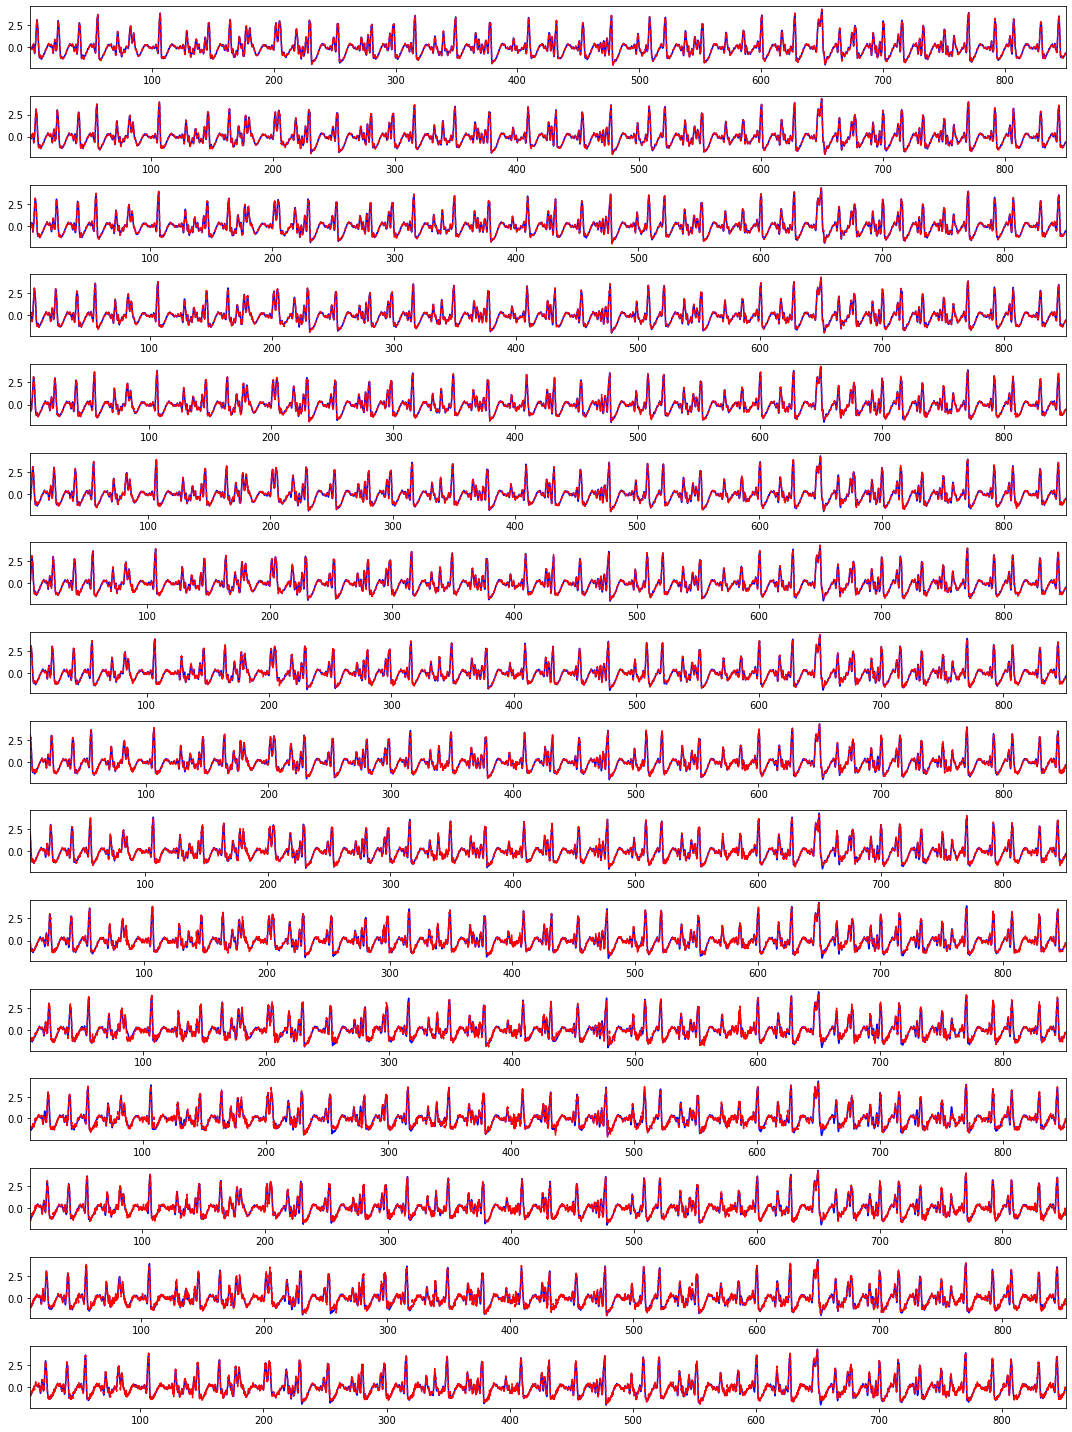

In [5]:
plot_taus = Taus
n_plots = len(plot_taus)
figure(figsize = (15, 1.25*n_plots))

for j in range(n_plots):
    
    subplot(n_plots, 1, j+1)
    
    m = len(Xi_Results[plot_taus[j]]['true'][417:])
    m_train = int(0.7*m)
    m_val = int(0.15*m)
    m_test = m-m_train-m_val
    t = (1000-0.01*np.arange(m))[::-1]
    
    plot(t,Xi_Results[plot_taus[j]]['true'][417:], 'b')
    
    plot(t,Xi_Results[plot_taus[j]]['NN'], 'r--')
#     fill_between(t,(Results[plot_taus[j]]['NN_mean']-Results[plot_taus[j]]['NN_std']).flatten(),
#                    (Results[plot_taus[j]]['NN_mean']+Results[plot_taus[j]]['NN_std']).flatten(),
#                  color='r', alpha=0.25)
    
    xlim([t[0],t[m_train+m_val]])
    
tight_layout()

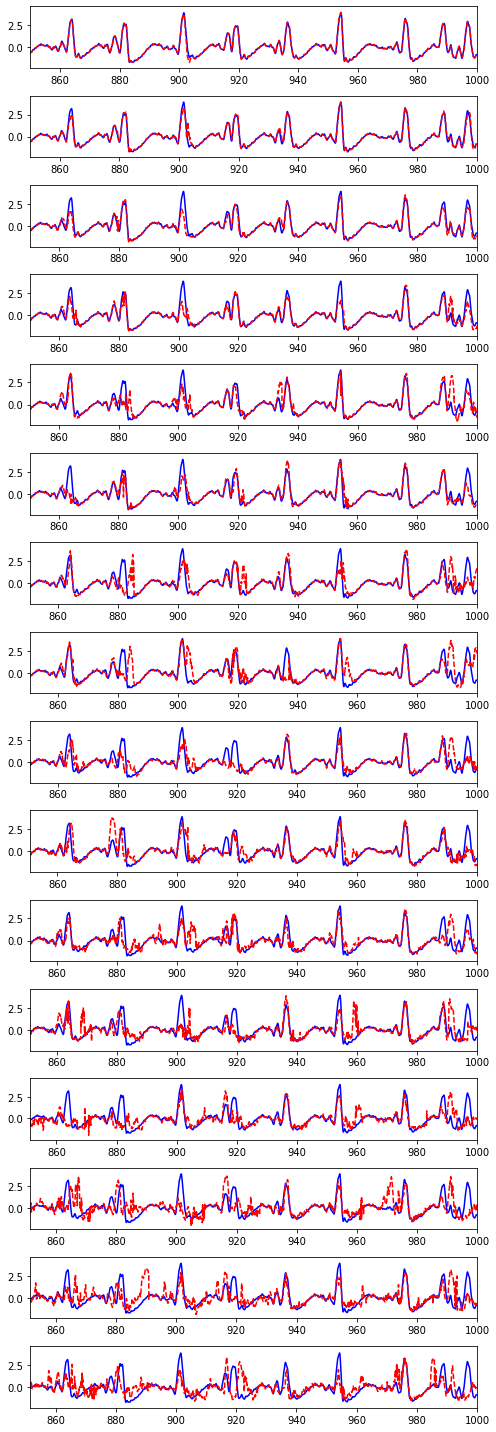

In [6]:
plot_taus = Taus
n_plots = len(plot_taus)

figure(figsize = (7, 1.25*n_plots))

for j in range(n_plots):
    
    subplot(n_plots, 1, j+1)
    
    m = len(Xi_Results[plot_taus[j]]['true'][417:])
    m_train = int(0.7*m)
    m_val = int(0.15*m)
    m_test = m-m_train-m_val
    t = (1000-0.01*np.arange(m))[::-1]
    
    plot(t,Xi_Results[plot_taus[j]]['true'][417:], 'b')
    
    plot(t,Xi_Results[plot_taus[j]]['NN'], 'r--')
#     fill_between(t,(Results[plot_taus[j]]['NN_mean']-Results[plot_taus[j]]['NN_std']).flatten(),
#                    (Results[plot_taus[j]]['NN_mean']+Results[plot_taus[j]]['NN_std']).flatten(),
#                  color='r', alpha=0.25)
    
    xlim([t[m_train+m_val],t[-1]])
    
tight_layout()

In [7]:
plot_taus = Taus

Xi_statistics = {'Alpha_star' : [],
                 'Q_opt' : [],
                 'F1' : [],
                 'MSE' : [],
                 'MAE' : [],
                 'WMSE' : []}

for j in tqdm(range(len(Taus))):
    
    alpha_star, q_opt, a_opt, b_opt = guth_criterion(Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten(), 
                                                     Xi_Results[plot_taus[j]]['NN'][m_train+m_val:].flatten(),
                                                     return_thresholds=True,
                                                     nq=51,
                                                     q_min=0.0,
                                                     q_max=0.5,
                                                     nb=501)
    
    Xi_statistics['F1'].append(F1_score(Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten(),
                       Xi_Results[plot_taus[j]]['NN'][m_train+m_val:].flatten(),a_opt,b_opt))
    Xi_statistics['Alpha_star'].append(alpha_star)
    Xi_statistics['Q_opt'].append(q_opt)
    Xi_statistics['MSE'].append(np.mean((Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten()-
                        Xi_Results[plot_taus[j]]['NN'][m_train+m_val:].flatten())**2))
    Xi_statistics['MAE'].append(np.mean(np.abs(Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten()-
                        Xi_Results[plot_taus[j]]['NN'][m_train+m_val:].flatten())))
    Xi_statistics['WMSE'].append(np.mean((Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten()-
                        Xi_Results[plot_taus[j]]['NN'][m_train+m_val:].flatten())**2 / 
                        (np.abs(Xi_Results[plot_taus[j]]['true'][417+m_train+m_val:].flatten())+0.1)))

100%|██████████| 16/16 [01:13<00:00,  4.56s/it]


In [8]:
mm = m_train + m_val

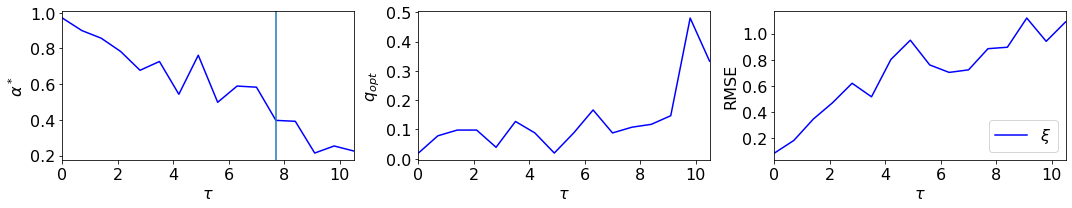

In [9]:
figure(figsize = (15,3))
label_fs = 16

subplot(1,3,1)
plot(Taus, Xi_statistics['Alpha_star'], 'b')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'$\alpha^*$', fontsize = label_fs)
axvline(7.7)

subplot(1,3,2)
plot(Taus, Xi_statistics['Q_opt'], 'b')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'$q_{opt}$', fontsize = label_fs)

subplot(1,3,3)
plot(Taus, [m**0.5 for m in Xi_statistics['MSE']], 'b', label=r'$\xi$')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'RMSE', fontsize = label_fs)
legend(loc='lower right', fontsize = label_fs)

tight_layout()

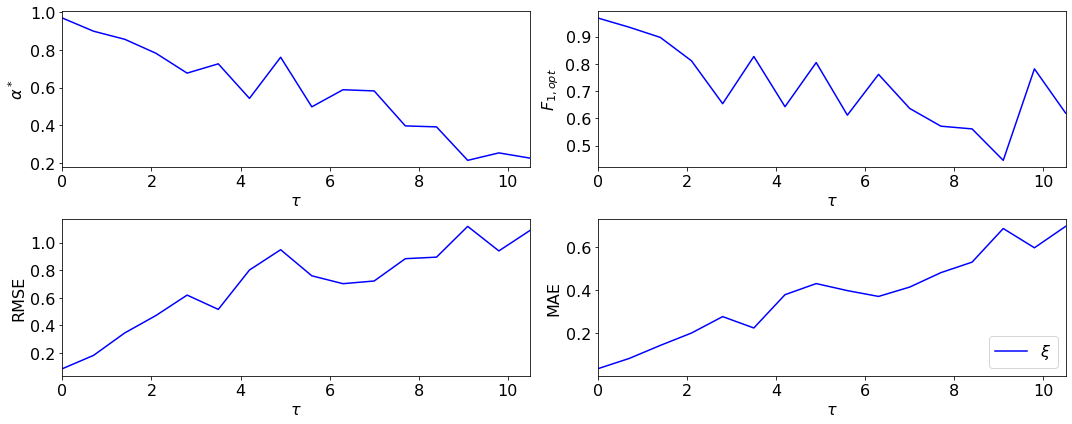

In [10]:
figure(figsize = (15,6))

subplot(2,2,1)
plot(Taus, Xi_statistics['Alpha_star'], 'b')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'$\alpha^*$', fontsize = label_fs)

subplot(2,2,2)
plot(Taus, Xi_statistics['F1'], 'b')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'$F_{1,opt}$', fontsize = label_fs)

subplot(2,2,3)
plot(Taus, [m**0.5 for m in Xi_statistics['MSE']], 'b', label=r'$\xi$')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'RMSE', fontsize = label_fs)

subplot(2,2,4)
plot(Taus, Xi_statistics['MAE'], 'b', label=r'$\xi$')
xlim([0,np.max(Taus)])
xticks(fontsize = label_fs)
yticks(fontsize = label_fs)
xlabel(r'$\tau$', fontsize = label_fs)
ylabel(r'MAE', fontsize = label_fs)
legend(loc='lower right', fontsize = label_fs)

tight_layout()

In [11]:
mm = m_train + m_val

In [12]:
EE_rates = np.linspace(0,0.25,26)[1:]

Xi_F1_train = np.zeros((len(EE_rates), len(Taus)))
Xi_F1_test = np.zeros((len(EE_rates), len(Taus)))
Xi_AUC_test = np.zeros((len(EE_rates), len(Taus)))

for i in tqdm(range(len(EE_rates))):
    for j in range(len(Taus)):

        a = Xi_Results[Taus[j]]['true'][417:mm+417].flatten()
        b = Xi_Results[Taus[j]]['NN'][:mm].flatten()
        a_hat, B_hat, F1_scores = F1_vals(a,b,EE_rates[i])
        Xi_F1_train[i,j] = np.max(F1_scores)
        
        a = Xi_Results[Taus[j]]['true'][mm+417:].flatten()
        b = Xi_Results[Taus[j]]['NN'][mm:].flatten()
        Xi_F1_test[i,j] = F1_score(a,b,EE_rates[i],B_hat[np.argmax(F1_scores)])
        Xi_AUC_test[i,j] = guth_AUC(a,b,EE_rates[i])

100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


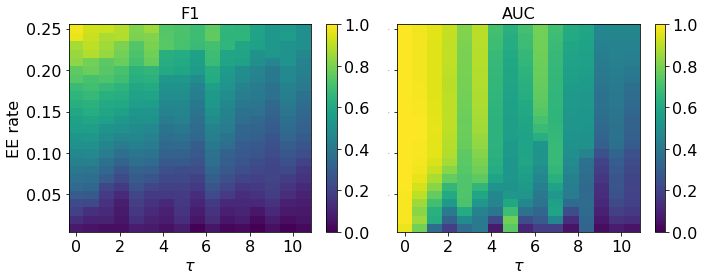

In [13]:
figure(figsize = (10,4))

subplot(1,2,1)
vmin = 0#np.min(Xi_F1_test)
vmax = 1#np.max(Xi_F1_test)
pcolor(Taus, EE_rates, Xi_F1_test, shading='auto', vmin=vmin, vmax=vmax)
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
title(r'F1', fontsize = label_fs)
xticks(fontsize=label_fs)
yticks(fontsize=label_fs)
xlabel(r'$\tau$', fontsize=label_fs)
ylabel(r'EE rate', fontsize=label_fs)

subplot(1,2,2)
vmin = 0#np.min(Xi_AUC_test.clip(0,1))
vmax = 1#np.max(Xi_AUC_test.clip(0,1))
pcolor(Taus, EE_rates, Xi_AUC_test.clip(0,1), shading='auto', vmin=vmin, vmax=vmax)
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
xticks(fontsize=label_fs)
yticks(fontsize=0)
xlabel(r'$\tau$', fontsize=label_fs)
title(r'AUC', fontsize=label_fs)

tight_layout()